# Epidemics on networks: the SI model
The goal of this assignment will be to implement a working SIS model on a network and reproduce a figure from this week's readings. We will start with an SI model as a template which you can then expand upon to build the SIS model.

I will put together a function that will be able to take as input networkx graphs. In the SI model, a fraction of nodes begin as infected and then new infections spread throughout the network across the links with some probability `beta`. If the dice rolls out of the nodes favor then it becomes infected and can then infect other nodes that it neighbors.

In a connected graph, the SI model should eventually infect everyone as t -> infinity because there will always be a non-zero probability of transmission. Alternatively, the SIS model will reach an equilibrium point where there is a balance between infections and reversions to susceptibility.

Lets walk through building the SI model:

In [1]:
# We will be using numpy and networkx for our function
import networkx as nx
import numpy as np

In [2]:
# There will be 4 parameters for the model:
# (graph) The networkx graph 
# (tmax) The maximum time that we will run the model 
# (beta) The transmission probability 
# (initial_inf) The initial fraction of infected nodes
def SI(graph, tmax, beta, initial_inf):
    inf_o = set(np.random.choice(graph.nodes(), size=int(len(graph) * initial_inf), replace=False))
    nx.set_node_attributes(graph, {node: ([1] if node in inf_o else [0]) for node in graph.nodes()},'inf')
    for t in range(tmax):
        for node in graph.nodes():
            if graph.nodes[node]['inf'][t] == 0:           
                # First determine how many infected neighbors the node has at time t:
                num_inf_neighbors = np.sum([ graph.nodes[neighbor]['inf'][t] for neighbor in graph.neighbors(node)])
                # Instead of drawing a bunch of random numbers for each neighbor
                # we  can just calculate the cumulative probability of getting
                # infected since these events are independent and then just
                # draw 1 random number to check against:
                if np.random.random() < (1 - (1 - beta)**num_inf_neighbors):
                    # If infection occurs we add a 1 to the state list of the node.
                    # Note that by doing this we don't change how the other 
                    # nodes update, because they will be using time index t not t+1
                    graph.nodes[node]['inf'].append(1)
                    
                else:
                    # If no infection occurs, then just append the current state
                    graph.nodes[node]['inf'].append(graph.nodes[node]['inf'][t])
                    
            # Similarly, if the node is already infected it can't change back
            # So we append the current state if it wasn't susceptible
            else:
                graph.nodes[node]['inf'].append(graph.nodes[node]['inf'][t])
                
    # Once the updates have run their course for all nodes up to tmax we can
    # return the time-series of the fraction of infected nodes
    # It is easy to calculate because I let infected be 1, so the 
    # fraction infected is just the mean of the population at time t:
    return [ np.mean([ graph.nodes[node]['inf'][t] for node in graph.nodes() ]) for t in range(tmax)]

And there we have our SI model. The function is mostly comments, there are only a dozen lines of code involved in the whole process. Lets give it a run:

In [3]:
# Lets generate a random graph for testing
rnd_graph = nx.erdos_renyi_graph(100, 0.1)

# We want to make sure that the graph is connected, so we will only take the largest
# connected component, as disconnected parts can't be infected or transmit infection:
largest_component = max(nx.connected_components(rnd_graph), key=len)
# above returns a set of nodes, so we use it to creat a subgraph
largest_component = rnd_graph.subgraph(largest_component)

In [4]:
largest_component

In [5]:
# Now lets plot it
%matplotlib inline
import matplotlib.pyplot as plt

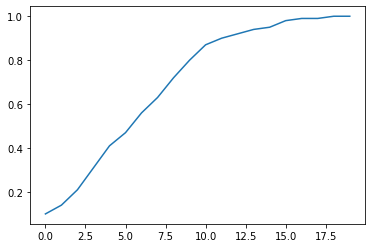

In [6]:
plt.plot(SI(largest_component, tmax=20, beta=0.05, initial_inf=0.1))

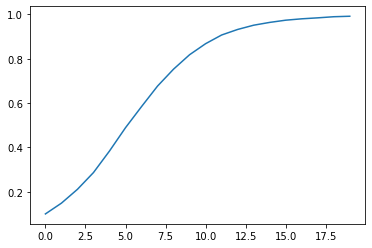

In [7]:
# Since it is a random process we want to do a couple
# sample runs to smooth out the curve

plt.plot( np.mean([SI(rnd_graph, tmax=20, beta=0.05, initial_inf=0.1) for i in range(50)], axis=0) )

The axis argument in `numpy.mean` tells you which axis to apply the average over, since we have a two-dimensional array (time on one axis and trials on the other). If I picked `axis=1` instead, it would have run the average over time rather than the number of trials.

This curve is much smoother than the previous one. You will find that this sort of averaging over trials is necessary when dealing with noisy or random models.

We can see that at 10% initial infected population and an infection rate of 5% we infect the whole 100 node network within 20 time steps. Most of the growth occurs in the middle after the disease ramps up, and then slows as most of the population is already infected.

# Assignment: Building the SIS model
The example SI model should give you a good starting point from which to create the SIS version. In the SIS model, infected nodes can transform back to susceptible nodes, which means you will have one additional parameter that needs to be provided as an argument to the model. Lets call this probability of reversion `gamma`. You can either start with the SI function I provided and modify it into the SIS variant, or you can write your own function to taste. 

My implementation is simple but far from optimal, it will be slower to run on larger and more dense graphs. If you want more of a challenge try comming up with an SIS version that can run efficiently on larger graphs. This could be done by relying more heavily on numpy, which uses a c backend for array operations, or using a different network data structure.

Here are your goals:

1. Create an SIS version of the function, either by building off of mine or making your own from scratch.
2. Plot your model's results (fraction of suspecitilbe and infectious population) using a fully connecte netowrk with nx.complete_graph(n) and play with the parameters `n`= 1000, `gamma`=0.04, `beta`=0.05, and `initial_inf`=0.1. Infected fraction at equalibram will be 1 - (0.8) = 0.2
3. Plot your model's results using a fully connecte netowrk with nx.erdos_renyi_graph(n) and play with the parameters `n`= 1000, `p`= 0.1, `gamma`=0.04, `beta`=0.05, and `initial_inf`=0.1. Infected fraction at equalibram will be 1 - (0.8) = 0.2. Compare the result with problem 2, and leave the simple note in notebooks

In [42]:
# We will be using numpy and networkx for our function
import networkx as nx
import numpy as np

In [43]:
# There will be 5 parameters for the model:
# (graph) The networkx graph 
# (tmax) The maximum time that we will run the model 
# (beta) The transmission probability 
# (gamma) The reversion probability
# (initial_inf) The initial fraction of infected nodes
def SIS(graph, tmax, beta, gamma, initial_inf):
    inf_o = set(np.random.choice(graph.nodes(), size=int(len(graph) * initial_inf), replace=False))
    nx.set_node_attributes(graph, {node: ([1] if node in inf_o else [0]) for node in graph.nodes()},'inf')
    for t in range(tmax):
        for node in graph.nodes():
            if graph.nodes[node]['inf'][t] == 0:           
                # First determine how many infected neighbors the node has at time t:
                num_inf_neighbors = np.sum([ graph.nodes[neighbor]['inf'][t] for neighbor in graph.neighbors(node)])
                # Instead of drawing a bunch of random numbers for each neighbor
                # we  can just calculate the cumulative probability of getting
                # infected since these events are independent and then just
                # draw 1 random number to check against:
                # if we get infected from more than one neighbor, then we get infected
                # 1 - p(not getting infected for all neighbors) = p(getting infected)
                if np.random.random() < (1 - (1 - beta)**num_inf_neighbors): 
                    # If infection occurs we add a 1 to the state list of the node.
                    # Note that by doing this we don't change how the other 
                    # nodes update, because they will be using time index t not t+1
                    graph.nodes[node]['inf'].append(1)
                    
                else:
                    # If no infection occurs, then just append the current state
                    graph.nodes[node]['inf'].append(graph.nodes[node]['inf'][t])
                    
            # if the node is already infected it can heal by probability gamma
            else:
                if np.random.random() < gamma:
                    # heal
                    graph.nodes[node]['inf'].append(0)
                else:
                    # no heal
                    graph.nodes[node]['inf'].append(graph.nodes[node]['inf'][t])
                
    # Once the updates have run their course for all nodes up to tmax we can
    # return the time-series of the fraction of infected nodes
    # It is easy to calculate because I let infected be 1, so the 
    # fraction infected is just the mean of the population at time t:
    return [ np.mean([ graph.nodes[node]['inf'][t] for node in graph.nodes() ]) for t in range(tmax)]

In [44]:
# Now lets plot it
%matplotlib inline
import matplotlib.pyplot as plt

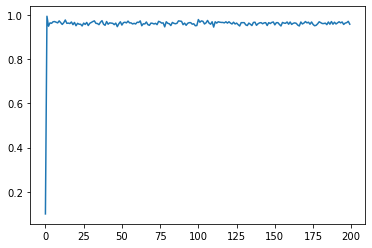

In [45]:
full_graph = nx.complete_graph(1000)

plt.plot(SIS(full_graph, tmax=200, beta=0.05, gamma=0.04, initial_inf=0.1))
#plt.plot( np.mean([SIS(full_graph, tmax=20, beta=0.05, gamma=0.04, initial_inf=0.1) for i in range(50)], axis=0) )

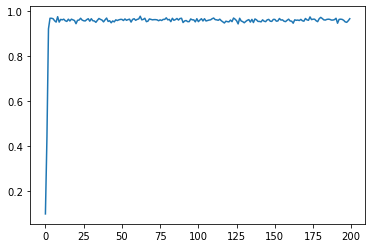

In [34]:
rnd_graph = nx.erdos_renyi_graph(1000, 0.1)

# We want to make sure that the graph is connected, so we will only take the largest
# connected component, as disconnected parts can't be infected or transmit infection:
largest_component = max(nx.connected_components(rnd_graph), key=len)
# above returns a set of nodes, so we use it to creat a subgraph
largest_component = rnd_graph.subgraph(largest_component)

plt.plot(SIS(largest_component, tmax=200, beta=0.05, gamma=0.04, initial_inf=0.1))
#plt.plot( np.mean([SIS(largest_component, tmax=20, beta=0.05, gamma=0.04, initial_inf=0.1) for i in range(50)], axis=0) )

Comapared with the complete graph, the erdos-renyi graph takes more time to converge,  
since it has fewer connections, so it is harder to get infected.